# Guided Project: Analyzing High School Data

**Over the last three missions, we explored relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.<br><br>For the purposes of this project, we'll be using data about New York City public schools, which can be found <a href="https://data.cityofnewyork.us/browse?category=Education">here</a>.<br> Below are the datasets that we will be using:**

<a href="https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4">SAT scores by school</a> - SAT scores for each high school in New York City<br>
<a href="https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt">School attendance</a> - Attendance information for each school in New York City<br>
<a href="https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3">Class size</a> - Information on class size for each school<br>
<a href="https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e">AP test results</a> - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)<br>
<a href="https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a">Graduation outcomes</a> - The percentage of students who graduated, and other outcome information<br>
<a href="https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j">Demographics</a> - Demographic information for each school<br>
<a href="https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8">School survey</a> - Surveys of parents, teachers, and students at each school<br>

**All of these data sets are interrelated. We've combined all of them into a single data set *<font color=blue>combined</font>* which will be used in our analysis, to find correlations.**


### Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/home/naveen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


### Add/Modify DBN columns in class_size and hs_directory

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert numeric columns from Object type to numeric and Add Longitude and Latitude Columns

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
        
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Combine the datasets

In [6]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [7]:
combined

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000000,404.000000,363.000000,1122.000000,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000000,423.000000,366.000000,1172.000000,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000000,402.000000,370.000000,1149.000000,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000000,433.000000,384.000000,1207.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.000000,574.000000,525.000000,1621.000000,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.000000,393.000000,392.000000,1194.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517
8,02M294,ESSEX STREET ACADEMY,53,394.000000,384.000000,378.000000,1156.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517


### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations
1. Set up matplotlib to work in Jupyter notebook.
2. There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.
    - You can find a list of the fields in the survey_fields variable in the notebook.
3. Consult the data dictionary that's part of the zip file you can download from the City of New York's website.
    - Did you find any surprising correlations?
4. Write up your results in a Markdown cell.

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
combined.corr()['sat_score'][survey_fields].plot.bar()
plt.show()

<Figure size 640x480 with 1 Axes>

### Key Observations:

- `N_s`, `N_t`, `N_p` correlate highly with `sat_score`. Since these fields are directly related to total enrollment, this can be understood.
- `rr_s` (Student Response Rate) however is the more interesting point. Since, students who excel academically are more likely to respond to a survey regarding `sat_score`.
- `saf_t_11`, `saf_s_11`, `saf_tot_11` gives us another good perspective about the relationship between a safe environment and academic brilliance. Schools where Students and Teachers feel safe are more likely to have good `sat_score`.
- `aca_s_11` i.e. how students percieve academic standards correlates highly for `sat_score`. However, same is not true for `aca_p_11` and `aca_t_11`, i.e. how Parents and Teachers perceive academic standards. 

******

## Exploring Safety and SAT Scores

1. Investigate safety scores.
    - Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.
    - Write up your conclusions about safety and SAT scores in a Markdown cell.
2. Map out safety scores.
    - Compute the average safety score for each district.
    - Make a map that shows safety scores by district.
    - Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the <a href='http://www.nycgo.com/boroughs-neighborhoods'>boroughs of New York City</a>.

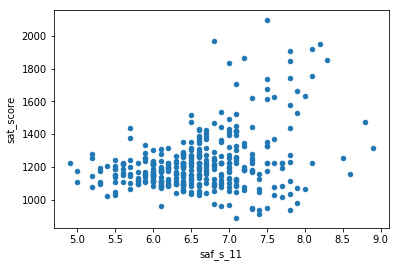

In [12]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.show()

**From the Scatter Plot, we can observe that there seems to be a positive correlation between the `sat_score` and `saf_s_11`, although its not that strong.**

In [13]:
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)
districts

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
5,06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,10.0,...,12.0,12.0,10463.181818,757.863636,1.500000,0.0,0.0,0.0,40.870345,-73.898360


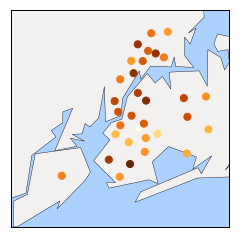

In [14]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#ABD1FF')
m.drawcoastlines(color='black', linewidth=.4)
m.drawrivers(color='#ABD1FF', linewidth=.4)
m.fillcontinents(color= '#F2F1EF',lake_color='#ABD1FF')
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['saf_tot_11'], cmap='YlOrBr')
plt.show()

**From the Map, we can observe that parts of _Manhattan, Bronx and Queens_ have relatively higher safety scores. While _Brooklyn_ has mostly lower safety scores.**
***

There are a few columns that indicate the percentage of each race at a given school:
    - white_per
    - asian_per
    - black_per
    - hispanic_per
By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

## Explore Race and SAT Scores

1. Investigate racial differences in SAT scores.
    - Make a bar plot of the correlations between the columns above and sat_score.
    - Write up a Markdown cell containing your findings. Are there any unexpected correlations?
2. Explore schools with low SAT scores and high values for hispanic_per.
    - Make a scatter plot of hispanic_per vs. sat_score.
    - What does the scatter plot show? Record any interesting observsations in a Markdown cell.
3. Research any schools with a hispanic_per greater than 95%.
    - Find the school names in the data.
    - Use Wikipedia and Google to research the schools by name.
    - Is there anything interesting about these particular schools? Record your findings in a Markdown cell.
4. Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
    - Find the school names in the data.
    - Use Wikipedia and Google to research the schools by name.
    - Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

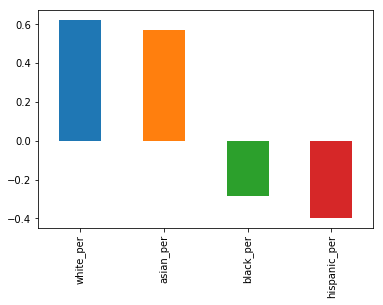

In [15]:
races_per = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][races_per].plot.bar()
plt.show()

**From the bar plot above we can notice that higher percentage of White or Asian students at a school correlates with higher SAT Scores. And vice versa for Black and Hispanic Students. It can be due to various external factors, like economic background of students, funding to Schools, etc.**

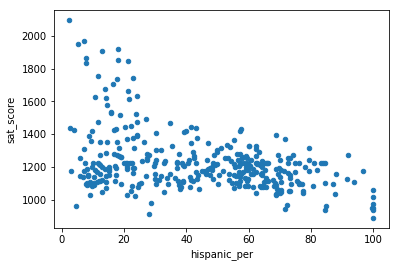

In [16]:
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.show()

**There seems to be a negative correlation between hispanic students percentage and SAT Score.**

In [17]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

**We can observe from our findings that the above schools are catering mostly to the immigrant community, who have recently migrated to USA from neighboring hispanic countries. And are learning English, which can be correlated to lower SAT Scores.**

In [18]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

**We can observe from our findings that the above schools are sepcialized in Science & Technology. And have  a criteria (clearing specific entrance exams) for admitting students, which explaining the High SAT Scores. But, there is no specific reason for low Hispanic proportion of students.**
***

There are two columns that indicate the percentage of each gender at a school:

- male_per
- female_per<br>

We can plot out the correlations between each percentage and sat_score.

## Exploring Gender and SAT Scores

1. Investigate gender differences in SAT scores.
    - Make a bar plot of the correlations between the columns above and sat_score.
    - Record your findings in a Markdown cell. Are there any unexpected correlations?
2. Investigate schools with high SAT scores and a high female_per.
    - Make a scatter plot of female_per vs. sat_score.
    - What does the scatter plot show? Record any interesting observations in a Markdown cell.
3. Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.
    - Find the school names in the data.
    - Use Wikipedia and Google to research the schools by name.
    - Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

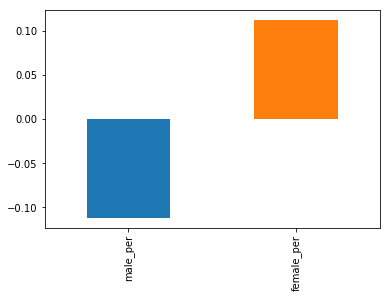

In [19]:
gender_per = ['male_per', 'female_per']
combined.corr()['sat_score'][gender_per].plot.bar()
plt.show()

**Here, from the bar plot we can observe that higher percentage of Female Students correlates positively with SAT Scores and vice versa for Male Students. However neither of the correlations are strong.**

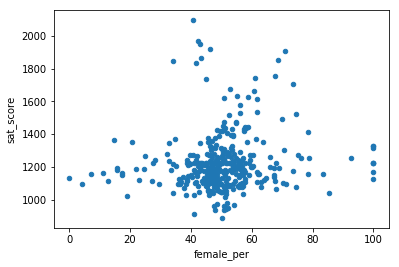

In [20]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.show()

**From the scatter plot above, there doesn't seem to be any strong correlation among the SAT Scores and Female Percentage.**

In [21]:
combined[(combined['sat_score'] > 1700) & (combined['female_per'] > 60)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

**From our findings, we notice that the above schools have their major focus primarily on two things:**
- **Arts**
- **Preparing students for college**

## Exploring AP Scores Vs. SAT Scores 
1. Calculate the percentage of students in each school that took an AP exam.
    - Divide the AP Test Takers column by the total_enrollment column.
        - The column name AP Test Takers has a space at the end -- don't forget to add it!
    - Assign the result to the ap_per column.
2. Investigate the relationship between AP scores and SAT scores.
    - Make a scatter plot of ap_per vs. sat_score.
    - What does the scatter plot show? Record any interesting observations in a Markdown cell.

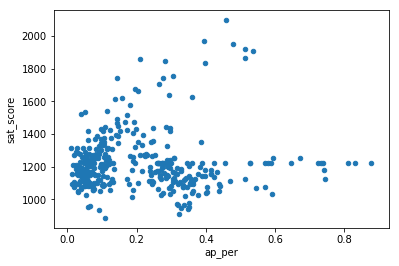

In [22]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')
plt.show()

**Here, we can observe that there is a weak correlation between AP Test Takers and SAT Scores.**